In [33]:
# STEP 1: IMPORTS & SETUP

import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Preprocessing & Clustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Autoencoder Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError

# Hybrid Model (Supervised)
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from scipy.stats import ks_2samp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries Imported Successfully.")


Libraries Imported Successfully.


In [20]:
# STEP 2: LOAD & PREPARE DATA

file_name = 'application_train_FinalEDA.csv'
try:
    X_df = pd.read_csv(file_name)
    print(f"Successfully loaded {file_name}")
except FileNotFoundError:
    print(f"ERROR: Could not find the file named {file_name}.")
    print("Please upload your file to Colab and try again.")
    raise

print("\n--- Dataset Info ---")
X_df.info()

target_column_name = 'TARGET'

if target_column_name not in X_df.columns:
    print(f"\n\nERROR: The column '{target_column_name}' was not found in your data.")
    print("Please update the 'target_column_name' variable to match your dataset.")
    raise ValueError("Target column not found")

y = X_df[target_column_name]
X_df = X_df.drop(columns=[target_column_name])

feature_names = X_df.columns.tolist()

print(f"\nSetup complete.")
print(f"Target (y) variable: '{target_column_name}'")
print(f"Features (X) shape: {X_df.shape}")

object_cols = X_df.select_dtypes(include='object').columns

if not object_cols.empty:
    print(f"\nFound object columns: {list(object_cols)}")
    print("Applying one-hot encoding...")

    X_df = pd.get_dummies(X_df, columns=object_cols, drop_first=True)

    feature_names = X_df.columns.tolist()
    print("One-hot encoding complete. New feature shape:", X_df.shape)
else:
    print("\nNo object columns found. Data is all numeric.")

X_df = X_df.astype(np.float32)

Successfully loaded application_train_FinalEDA.csv

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   CNT_CHILDREN                 307511 non-null  float64
 2   AMT_INCOME_TOTAL             307511 non-null  float64
 3   AMT_CREDIT                   307511 non-null  float64
 4   AMT_ANNUITY                  307511 non-null  float64
 5   REGION_POPULATION_RELATIVE   307511 non-null  float64
 6   DAYS_BIRTH                   307511 non-null  float64
 7   DAYS_EMPLOYED                307511 non-null  float64
 8   DAYS_REGISTRATION            307511 non-null  float64
 9   OWN_CAR_AGE                  307511 non-null  float64
 10  REGION_RATING_CLIENT         307511 non-null  float64
 11  HOUR_APPR_PROCESS_START      307511 non-null

In [12]:
# STEP 3: PREPROCESSING

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print("\nMissing values imputed.")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split, imputed, and scaled. Training shape: {X_train_scaled.shape}")


Missing values imputed.
Data split, imputed, and scaled. Training shape: (246008, 56)


In [15]:
# STEP 4: AUTOENCODER MODEL (FOR ANOMALY & REPRESENTATION)

input_dim = X_train_scaled.shape[1]
bottleneck_dim = 8

# Input layer
input_layer = Input(shape=(input_dim,), name="Input")
# Encoder layers
encoder = Dense(16, activation='relu', name="Encoder_1")(input_layer)
encoder = Dense(bottleneck_dim, activation='relu', name="Bottleneck")(encoder)
# Decoder layers
decoder = Dense(16, activation='relu', name="Decoder_1")(encoder)
decoder = Dense(input_dim, activation=None, name="Output")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder, name="Autoencoder")

encoder_model = Model(inputs=input_layer, outputs=encoder, name="Encoder")

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("\nTraining Autoencoder...")

autoencoder.fit(
    X_train_scaled[y_train == 0],  # Train only on "good" applicants
    X_train_scaled[y_train == 0],  # It tries to reconstruct itself
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)
print("Autoencoder training complete.")


Training Autoencoder...
Epoch 1/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.3051 - val_loss: 0.2058
Epoch 2/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.2091 - val_loss: 0.1857
Epoch 3/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.2333 - val_loss: 0.1811
Epoch 4/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2108 - val_loss: 0.1817
Epoch 5/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.1938 - val_loss: 0.1804
Epoch 6/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.2132 - val_loss: 0.1706
Epoch 7/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.1808 - val_loss: 0.1650
Epoch 8/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.1759 - val_loss: 0.1647
Epoch 9/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.1662 - val_loss: 0.1638
Epoch 10/10
6361/6361 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.1629 - val_loss: 0.1628
Autoencoder training complete.


In [26]:
# STEP 5: GENERATE HYBRID FEATURES (Error, Latent, Clusters)

print("\nGenerating new features from Autoencoder...")

# Feature 1: Reconstruction Error (Anomaly Score)
X_train_pred = autoencoder.predict(X_train_scaled)
X_test_pred = autoencoder.predict(X_test_scaled)

# Calculate the Mean Squared Error for each sample
train_recon_errors = np.mean((X_train_scaled - X_train_pred)**2, axis=1)
test_recon_errors = np.mean((X_test_scaled - X_test_pred)**2, axis=1)

# Reshape for concatenation later
train_recon_errors = train_recon_errors.reshape(-1, 1)
test_recon_errors = test_recon_errors.reshape(-1, 1)

# Feature 2: Latent Features (Representation)
train_latent_features = encoder_model.predict(X_train_scaled)
test_latent_features = encoder_model.predict(X_test_scaled)


# Feature 3: Risk Profiles (Clustering)

nan_imputer = SimpleImputer(strategy='mean')

train_latent_features = nan_imputer.fit_transform(train_latent_features)
test_latent_features = nan_imputer.transform(test_latent_features)

print("NaN values in latent features have been imputed.")

n_clusters = 4 # e.g., Low, Medium, High, Anomaly
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

kmeans.fit(train_latent_features)

train_cluster_labels = kmeans.predict(train_latent_features)
test_cluster_labels = kmeans.predict(test_latent_features)

train_cluster_labels = pd.get_dummies(train_cluster_labels, prefix='cluster').values
test_cluster_labels = pd.get_dummies(test_cluster_labels, prefix='cluster').values

print("New features generated.")


Generating new features from Autoencoder...
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step
7688/7688 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
NaN values in latent features have been imputed.
New features generated.


In [27]:
# STEP 6: CREATE THE HYBRID DATASET

X_train_hybrid = np.hstack([
    X_train_scaled,
    train_recon_errors,
    train_latent_features,
    train_cluster_labels
])

X_test_hybrid = np.hstack([
    X_test_scaled,
    test_recon_errors,
    test_latent_features,
    test_cluster_labels
])

print(f"\nOriginal feature count: {X_train_scaled.shape[1]}")
print(f"Hybrid feature count: {X_train_hybrid.shape[1]} (original + error + latent + clusters)")


Original feature count: 56
Hybrid feature count: 69 (original + error + latent + clusters)


In [28]:
# STEP 7: TRAIN THE HYBRID LOGISTIC REGRESSION MODEL

print("\nTraining Hybrid Logistic Regression Model...")

hybrid_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

hybrid_model.fit(X_train_hybrid, y_train)

print("Hybrid model training complete.")


Training Hybrid Logistic Regression Model...
Hybrid model training complete.



--- Model Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56538
           1       0.15      0.65      0.24      4965

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503


--- Confusion Matrix ---


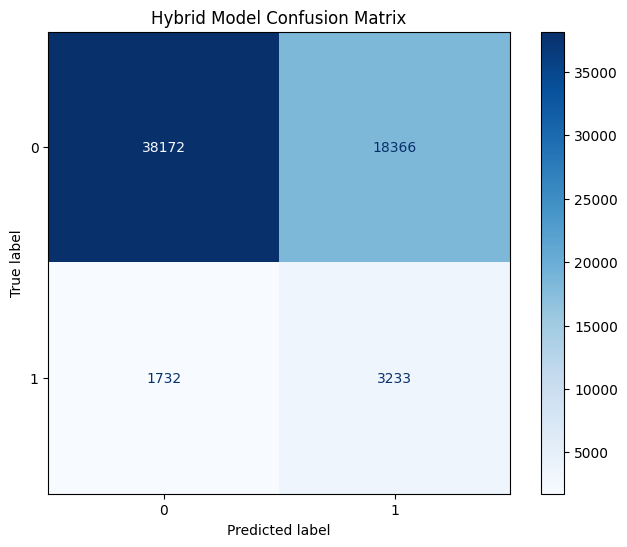

Area Under ROC Curve (AUC): 0.7240
Area Under Precision-Recall (PR-AUC): 0.2076
Kolmogorov-Smirnov (KS) Statistic: 0.3315


In [32]:
# STEP 8: MODEL EVALUATION

print("\n--- Model Evaluation ---")

# Get predictions
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
y_proba_hybrid = hybrid_model.predict_proba(X_test_hybrid)[:, 1]

# Classification Report (Precision-Recall)
print(classification_report(y_test, y_pred_hybrid))

# Confusion Matrix
print("\n--- Confusion Matrix ---")

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    hybrid_model,
    X_test_hybrid,
    y_test,
    cmap=plt.cm.Blues,
    ax=ax
)
plt.title('Hybrid Model Confusion Matrix')
plt.show()

# AUC (Area Under the ROC Curve)
auc_score = roc_auc_score(y_test, y_proba_hybrid)
print(f"Area Under ROC Curve (AUC): {auc_score:.4f}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba_hybrid)
pr_auc_score = auc(recall, precision)
print(f"Area Under Precision-Recall (PR-AUC): {pr_auc_score:.4f}")

# KS Statistic
ks_stat, p_value = ks_2samp(y_proba_hybrid[y_test == 0], y_proba_hybrid[y_test == 1])
print(f"Kolmogorov-Smirnov (KS) Statistic: {ks_stat:.4f}")


 Generating SHAP Explainability Report
SHAP values calculated.

--- SHAP Summary Plot ---
This shows the most important features for predicting default.


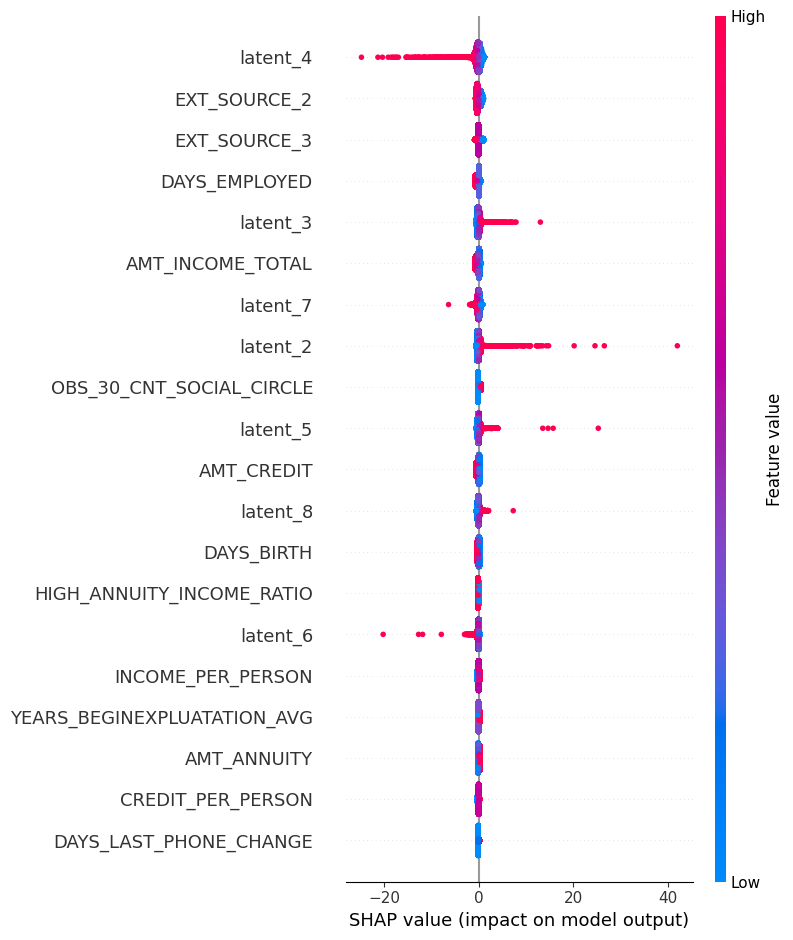


--- Anomaly Detection Plot ---


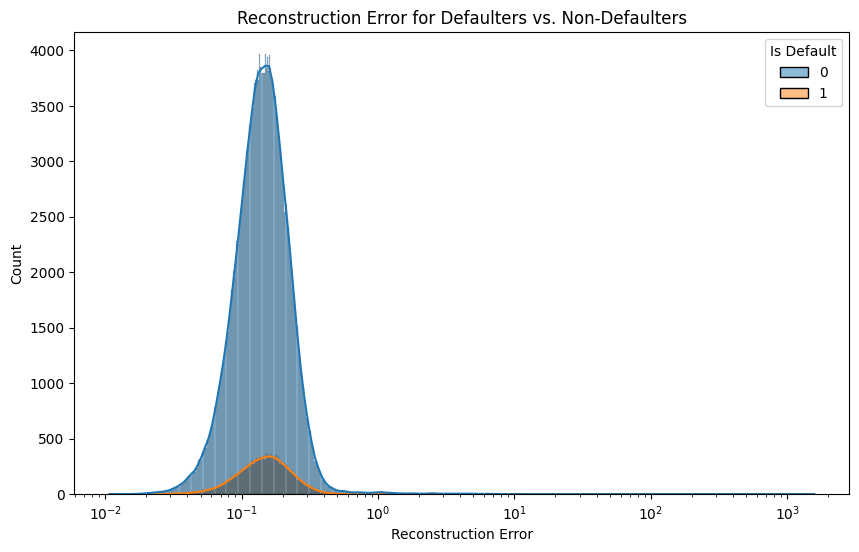


--- Project Complete ---


In [34]:
# STEP 9: EXPLAINABILITY & VISUALIZATION (using SHAP)

print("\n Generating SHAP Explainability Report")

# Create the list of all feature names for the report
new_feature_names = (
    feature_names +  # Original features
    ['RECON_ERROR'] + # New error feature
    [f'latent_{i+1}' for i in range(bottleneck_dim)] + # New latent features
    [f'cluster_{i}' for i in range(n_clusters)] # New cluster features
)

X_train_hybrid_df = pd.DataFrame(X_train_hybrid, columns=new_feature_names)
X_test_hybrid_df = pd.DataFrame(X_test_hybrid, columns=new_feature_names)

explainer = shap.LinearExplainer(hybrid_model, X_train_hybrid_df)

# Calculate SHAP values for our test set
shap_values = explainer.shap_values(X_test_hybrid_df)

print("SHAP values calculated.")

# Create the SHAP Summary Plot

print("\n--- SHAP Summary Plot ---")
print("This shows the most important features for predicting default.")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_hybrid_df, plot_type="dot", max_display=20)
plt.show()


# Visualize Anomaly Detection
print("\n--- Anomaly Detection Plot ---")
plt.figure(figsize=(10, 6))
plot_df = pd.DataFrame({
    'Reconstruction Error': train_recon_errors.flatten(),
    'Is Default': y_train
})
sns.histplot(
    data=plot_df,
    x='Reconstruction Error',
    hue='Is Default',
    kde=True,
    log_scale=True
)
plt.title('Reconstruction Error for Defaulters vs. Non-Defaulters')
plt.show()

print("\n--- Project Complete ---")